In [2]:
# German Car Classifier - Image Collection and Model Training

# This Jupyter notebook is designed to search, download, and classify images of German cars.
# It utilizes FastAI to train a deep learning model that can distinguish between different German car brands.

# Import necessary libraries

import fastai
import requests
import os
from duckduckgo_search import DDGS
from fastcore.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.data.all import *
from fastdownload import download_url


In [3]:
# Function to search and return images
def search_images(keywords, max_images=200):
    """
    Searches for images based on the provided keywords using DuckDuckGo.

    Args:
    keywords (str): The search term for the images.
    max_images (int): The maximum number of images to retrieve. Defaults to 200.

    Returns:
    L: A list-like object containing the URLs of the retrieved images.
    """
    print(f"Searching for '{keywords}'")
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [4]:
# Define the path where images will be stored
path = Path('/teamspace/studios/this_studio/german_cars')

In [5]:
# List of German car types to search for
car_types = ["bmw","audi","mercedes","volkswagen","porsche"]

# Search for and download images for each car type
for o in car_types:
    dest = (path/o)
    dest.mkdir(exist_ok = True) # Create the directory if it doesn't exist
    results = search_images(f'{o} cars') # Search for car images
    download_images(dest, urls = results) # Download the images to the respective folder


Searching for 'bmw cars'
Searching for 'audi cars'
Searching for 'mercedes cars'
Searching for 'volkswagen cars'
Searching for 'porsche cars'


In [6]:
ims = results.attrgot('contentUrl')
len(ims)

179

In [7]:
# Verify the downloaded images
fns = get_image_files(path)
fns

(#1443) [Path('/teamspace/studios/this_studio/german_cars/audi/01b8b841-3213-4909-99d9-da2647495f6b.jpg'),Path('/teamspace/studios/this_studio/german_cars/audi/02346a59-b8f5-49c1-b9f5-ec624fd13106.jpg'),Path('/teamspace/studios/this_studio/german_cars/audi/052cef42-2e81-4ca4-8f11-d705eb006a5d.png'),Path('/teamspace/studios/this_studio/german_cars/audi/071f8be7-e5f0-4cc9-abe2-9036f2dc96b0.jpg'),Path('/teamspace/studios/this_studio/german_cars/audi/08cddede-9cd2-430b-9160-d2185fd5f502.jpg'),Path('/teamspace/studios/this_studio/german_cars/audi/09966e7f-6748-4486-b6b2-58214a8616f5.jpg'),Path('/teamspace/studios/this_studio/german_cars/audi/0af2a28c-7b40-4ee1-8bcf-4880fa0abd95.jpg'),Path('/teamspace/studios/this_studio/german_cars/audi/0c5c96b7-fd4b-4b8c-aa80-a0d98b0adbff.jpg'),Path('/teamspace/studios/this_studio/german_cars/audi/0e011ab0-8694-4123-8625-eccdf305c011.jpg'),Path('/teamspace/studios/this_studio/german_cars/audi/0ee72181-22b0-4c59-892f-589e10bcf676.jpg')...]

In [8]:
# Identify any corrupted or invalid images
failed = verify_images(fns)

In [12]:
# Remove the invalid images
failed.map(Path.unlink)


(#27) [None,None,None,None,None,None,None,None,None,None...]

In [13]:
bs=64

In [14]:
# Set up data loaders for training the model
dls = ImageDataLoaders.from_folder(
    path,
    get_image_files(path),
    valid_pct=0.1, # 10% of the data is used for validation
    bs=bs,
    item_tfms=RandomResizedCrop(224, min_scale=0.5), # Image transformations
    batch_tfms=aug_transforms() # Data augmentation
)

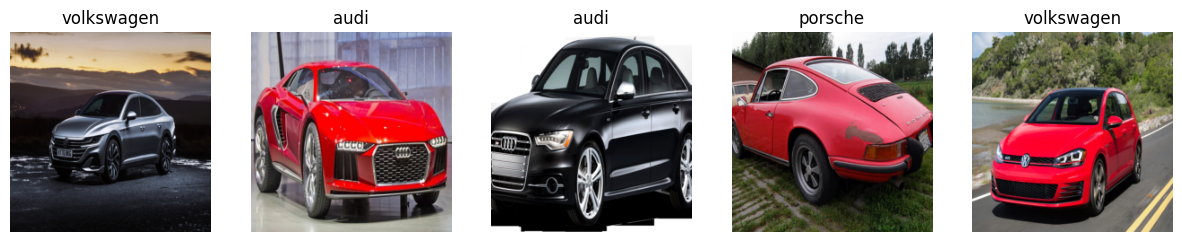

In [15]:
# Display a batch of images from the validation set
dls.valid.show_batch(max_n=5, nrows=1)

In [16]:
# Display some information about the data loaders
pd.Series({
    'Number of batches in train DataLoader:': len(dls.train),
    'Number of batches in validation DataLoader:': len(dls.valid)}
).to_frame().style.hide(axis='columns')

Number of batches in train DataLoader:,19
Number of batches in validation DataLoader:,3


In [19]:
# Train the model using transfer learning with a pretrained VGG16 model
learn = vision_learner(dls, vgg16_bn , metrics=[error_rate, accuracy])
learn.fine_tune(10)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.208386,0.921946,0.382979,0.617021,00:32


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.267498,0.665945,0.241135,0.758865,00:36
1,1.051400,0.511801,0.198582,0.801418,00:35
2,0.858598,0.286053,0.099291,0.900709,00:35
3,0.673058,0.244709,0.085106,0.914894,00:35
4,0.526654,0.186966,0.070922,0.929078,00:35
5,0.404083,0.180214,0.070922,0.929078,00:35
6,0.325232,0.151394,0.049645,0.950355,00:36
7,0.257550,0.142795,0.035461,0.964539,00:35
8,0.207665,0.129680,0.035461,0.964539,00:35
9,0.179202,0.129855,0.035461,0.964539,00:34


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  

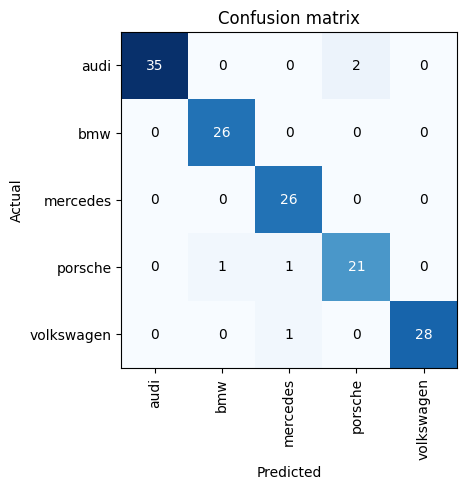

In [20]:
# Interpret the model's results
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

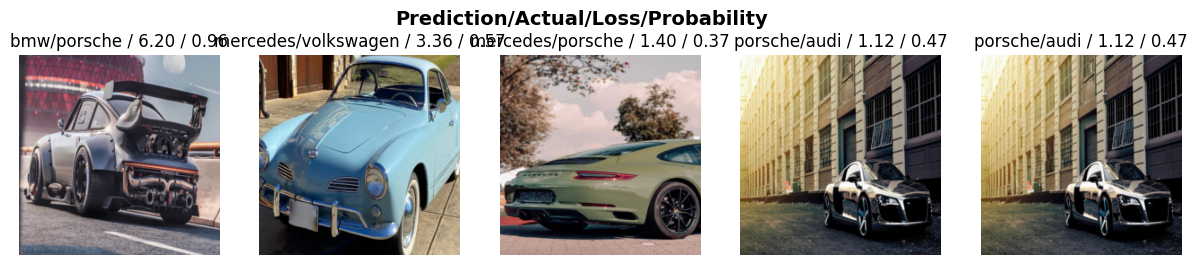

In [21]:
interp.plot_top_losses(5, nrows=1)

In [52]:
# Use ImageClassifierCleaner to help clean up misclassified images
cleaner = ImageClassifierCleaner(learn)
cleaner

In [24]:
# Export the trained model
learn.export()

In [25]:
# Load the exported model for inference
learn_inf = load_learner(path/'export.pkl')

In [32]:
# Example of using the model to make a prediction on a new image
btn_upload = SimpleNamespace(data = ['test/audi.jpg'])
img = PILImage.create(btn_upload.data[-1])

In [33]:
# Display the uploaded image
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [34]:
# Predict the class of the uploaded image
pred,pred_idx,probs = learn_inf.predict(img)

In [35]:
# Display the prediction and its probability
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: audi; Probability: 0.9999')